In [1]:
import configparser
import os
from joblib import dump, load
import json
from tqdm import tqdm
from helpers.helper_functions import *
from helpers.helper_classes import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels as sm
import numpy as np
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA

pd.set_option('display.max_rows', 200)

# Read config.ini file
config = configparser.ConfigParser()
config.read('src/config.ini')
# os.chdir(config['PATH']['ROOT_DIR'])

# # Load data from data folder joblib
# df = load(config['PATH']['DATA_DIR'] + '/df_cleaned.joblib') 
# df = load(config['PATH']['DATA_DIR'] + '/df_cleaned_nocap.joblib') 
# df = load(config['PATH']['DATA_DIR'] + '/df_cleaned_cap1.joblib') 
df = load(config['PATH']['DATA_DIR'] + '/df_cleaned_cap2.joblib') 




# Time to datetime
df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
df

c:\Users\caspa\OneDrive - Vrije Universiteit Amsterdam\VU Master\data-mining-techniques-vu\windows\data-mining-techniques-vu\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,id,time,variable,value
7,AS14.01,2014-03-21 09:00:00,mood,7.000000
8,AS14.01,2014-03-21 11:00:00,mood,6.542456
9,AS14.01,2014-03-21 15:00:00,mood,6.581664
10,AS14.01,2014-03-21 19:00:00,mood,6.617893
11,AS14.01,2014-03-21 21:00:00,mood,6.651368
...,...,...,...,...
380307,AS14.33,2014-05-22 21:00:00,circumplex.arousal,1.000000
380308,AS14.33,2014-05-23 09:00:00,circumplex.arousal,0.000000
380309,AS14.33,2014-05-25 18:00:00,circumplex.arousal,-2.000000
380310,AS14.33,2014-05-29 18:00:00,circumplex.arousal,-2.000000


In [2]:
# all variables
all_vars = df['variable'].unique()

In [3]:
appCat_vars = [var for var in df['variable'].unique() if 'appCat' in var]
avg_vars = ['mood', 'circumplex.arousal', 'circumplex.valence']
sum_vars = ['call', 'sms', 'screen', 'activity'] + appCat_vars
idc_vars = ['activity', 'call', 'sms']
moving_avg_vars = ['mood', 'circumplex.arousal', 'circumplex.valence']
count_vars = ['screen'] + appCat_vars
minmax_vars = ['mood', 'circumplex.arousal', 'circumplex.valence']
# # Create a dictionary of variables and their corresponding functions
var_dict = {'avg': avg_vars,'sum': sum_vars, 'idc': idc_vars, 'moving_avg': moving_avg_vars, 'count': count_vars, 'minmax': minmax_vars}

In [71]:
# Aggregate data to daily
rwindow_size = 3
df_agg = df

full_df_new = pd.DataFrame()
for person in df_agg['id'].unique():
    id = person
    min_date = df_agg[np.logical_and(df_agg['id'] == id, df_agg['variable'] == 'mood')]['time'].min()
    max_date = df_agg[np.logical_and(df_agg['id'] == id, df_agg['variable'] == 'mood')]['time'].max()

    # Get length of pd.date_range(start=min_date, end=max_date, freq='D')
    


    new_data = [{}] * len(pd.date_range(start=min_date, end=max_date, freq='D'))
    print(f"Aggregating for person {id} from {min_date} to {max_date}")
    for i, date in enumerate(tqdm(pd.date_range(start=min_date, end=max_date, freq='D'))):
        idx_date = np.logical_and(df_agg['time'].dt.date == date.date(), df_agg['id'] == id)
        # print(df_agg[idx_date])

        new_row = {'id': id, 'time': date.date()}
        for key, var_list in var_dict.items():
            for var in var_list:
                idx_var = np.logical_and(idx_date, df_agg['variable'] == var)
                if key == 'sum':
                    new_row[var + '_sum'] = df_agg[idx_var]['value'].sum()
                elif key == 'avg':
                    new_row[var + '_avg'] = df_agg[idx_var]['value'].mean()
                elif key == 'idc':
                    new_row[var + '_idc'] = 1 if df_agg[idx_var]['value'].sum() > 0 else 0
                elif key == 'count':
                    new_row[var + '_count'] = df_agg[idx_var]['value'].sum()
                elif key == 'minmax':
                    new_row[var + '_min'] = df_agg[idx_var]['value'].min()
                    new_row[var + '_max'] = df_agg[idx_var]['value'].max()

        # Special vars
        new_row['day_of_week'] = date.dayofweek
        
        new_data[i] = (new_row)
    
    new_df = pd.DataFrame(new_data)

    # full df features
    # Moving average
    for var in moving_avg_vars:
        new_df[var + '_moving_avg'] = new_df[var + '_avg'].rolling(rwindow_size).mean()
    # drop first 6 rows for NA moving avg
    new_df = new_df[rwindow_size-1:]

    # target is mean mood of following day
    new_df['target'] = new_df['mood_avg'].shift(-1)
    # drop last row for NA target
    new_df = new_df[:-1]

    full_df_new = pd.concat([full_df_new, new_df])
full_df_new = pd.concat([full_df_new, pd.get_dummies(full_df_new['day_of_week'], prefix='day_of_week')], axis=1)
full_df_new = full_df_new.drop(columns=['day_of_week'])



Aggregating for person AS14.01 from 2014-03-20 09:00:00 to 2014-05-04 21:00:00


100%|██████████| 46/46 [00:54<00:00,  1.19s/it]


Aggregating for person AS14.02 from 2014-03-16 09:00:00 to 2014-04-23 21:00:00


100%|██████████| 39/39 [00:46<00:00,  1.19s/it]


Aggregating for person AS14.03 from 2014-03-21 09:00:00 to 2014-05-07 21:00:00


100%|██████████| 48/48 [00:55<00:00,  1.16s/it]


Aggregating for person AS14.05 from 2014-03-14 09:00:00 to 2014-05-05 21:00:00


100%|██████████| 53/53 [01:02<00:00,  1.18s/it]


Aggregating for person AS14.06 from 2014-03-24 09:00:00 to 2014-05-08 21:00:00


100%|██████████| 46/46 [00:54<00:00,  1.18s/it]


Aggregating for person AS14.07 from 2014-03-19 11:00:00 to 2014-05-04 21:00:00


100%|██████████| 47/47 [00:55<00:00,  1.19s/it]


Aggregating for person AS14.08 from 2014-03-13 09:00:00 to 2014-05-05 21:00:00


100%|██████████| 54/54 [01:08<00:00,  1.26s/it]


Aggregating for person AS14.09 from 2014-03-21 09:00:00 to 2014-04-26 21:00:00


100%|██████████| 37/37 [00:52<00:00,  1.41s/it]


Aggregating for person AS14.12 from 2014-03-27 09:00:00 to 2014-05-05 21:00:00


100%|██████████| 40/40 [00:48<00:00,  1.22s/it]


Aggregating for person AS14.13 from 2014-03-13 09:00:00 to 2014-05-03 21:00:00


100%|██████████| 52/52 [01:05<00:00,  1.25s/it]


Aggregating for person AS14.14 from 2014-03-21 09:00:00 to 2014-05-05 21:00:00


100%|██████████| 46/46 [01:00<00:00,  1.32s/it]


Aggregating for person AS14.15 from 2014-03-14 09:00:00 to 2014-05-06 21:00:00


100%|██████████| 54/54 [01:10<00:00,  1.31s/it]


Aggregating for person AS14.16 from 2014-03-13 09:00:00 to 2014-05-05 21:00:00


100%|██████████| 54/54 [01:07<00:00,  1.25s/it]


Aggregating for person AS14.17 from 2014-03-20 09:00:00 to 2014-05-05 21:00:00


100%|██████████| 47/47 [00:59<00:00,  1.28s/it]


Aggregating for person AS14.19 from 2014-03-21 09:00:00 to 2014-05-05 21:00:00


100%|██████████| 46/46 [00:58<00:00,  1.27s/it]


Aggregating for person AS14.20 from 2014-03-20 09:00:00 to 2014-04-29 22:00:00


100%|██████████| 41/41 [00:59<00:00,  1.44s/it]


Aggregating for person AS14.23 from 2014-03-22 09:00:00 to 2014-04-30 21:00:00


100%|██████████| 40/40 [00:49<00:00,  1.24s/it]


Aggregating for person AS14.24 from 2014-04-14 09:00:00 to 2014-06-08 21:00:00


100%|██████████| 56/56 [01:13<00:00,  1.31s/it]


Aggregating for person AS14.25 from 2014-04-08 09:00:00 to 2014-05-08 21:00:00


100%|██████████| 31/31 [00:39<00:00,  1.28s/it]


Aggregating for person AS14.26 from 2014-04-13 11:00:00 to 2014-05-29 21:00:00


100%|██████████| 47/47 [00:57<00:00,  1.23s/it]


Aggregating for person AS14.27 from 2014-04-03 09:00:00 to 2014-05-14 23:00:00


100%|██████████| 42/42 [00:51<00:00,  1.23s/it]


Aggregating for person AS14.28 from 2014-03-31 09:00:00 to 2014-05-08 21:00:00


100%|██████████| 39/39 [00:49<00:00,  1.28s/it]


Aggregating for person AS14.29 from 2014-04-02 09:00:00 to 2014-05-14 21:00:00


100%|██████████| 43/43 [01:00<00:00,  1.40s/it]


Aggregating for person AS14.30 from 2014-03-20 09:00:00 to 2014-05-04 21:00:00


100%|██████████| 46/46 [01:00<00:00,  1.32s/it]


Aggregating for person AS14.31 from 2014-04-02 09:00:00 to 2014-05-07 21:00:00


100%|██████████| 36/36 [00:50<00:00,  1.41s/it]


Aggregating for person AS14.32 from 2014-04-01 09:00:00 to 2014-05-12 21:00:00


100%|██████████| 42/42 [00:58<00:00,  1.39s/it]


Aggregating for person AS14.33 from 2014-04-16 09:00:00 to 2014-05-30 20:00:00


100%|██████████| 45/45 [00:55<00:00,  1.24s/it]


['./data/full_df_agg_cap95.joblib']

In [81]:
dump(full_df_new, config['PATH']['DATA_DIR'] + '/full_df_agg_cap95.joblib')

['./data/full_df_agg_cap95.joblib']

In [5]:
rwindow_size = 3
df_agg = df

full_df_new = pd.DataFrame()
for person in df_agg['id'].unique():
    id = person
    min_date = df_agg[np.logical_and(df_agg['id'] == id, df_agg['variable'] == 'mood')]['time'].min()
    max_date = df_agg[np.logical_and(df_agg['id'] == id, df_agg['variable'] == 'mood')]['time'].max()

    # Get length of pd.date_range(start=min_date, end=max_date, freq='D')
    


    new_data = [{}] * len(pd.date_range(start=min_date, end=max_date, freq='D'))
    print(f"Aggregating for person {id} from {min_date} to {max_date}")
    for i, date in enumerate(tqdm(pd.date_range(start=min_date, end=max_date, freq='D'))):
        idx_date = np.logical_and(df_agg['time'].dt.date == date.date(), df_agg['id'] == id)
        # print(df_agg[idx_date])

        new_row = {'id': id, 'time': date.date()}
        for key, var_list in var_dict.items():
            for var in var_list:
                idx_var = np.logical_and(idx_date, df_agg['variable'] == var)
                if key == 'sum':
                    new_row[var + '_sum'] = df_agg[idx_var]['value'].sum()
                elif key == 'avg':
                    new_row[var + '_avg'] = df_agg[idx_var]['value'].mean()
                elif key == 'idc':
                    new_row[var + '_idc'] = 1 if df_agg[idx_var]['value'].sum() > 0 else 0
                elif key == 'count':
                    new_row[var + '_count'] = df_agg[idx_var]['value'].sum()
                elif key == 'minmax':
                    new_row[var + '_min'] = df_agg[idx_var]['value'].min()
                    new_row[var + '_max'] = df_agg[idx_var]['value'].max()

        # Special vars
        new_row['day_of_week'] = date.dayofweek
        
        new_data[i] = (new_row)
    
    new_df = pd.DataFrame(new_data)

    # target is mean mood of following day
    new_df['target'] = new_df['mood_avg'].shift(-1)
    # drop last row for NA target
    new_df = new_df[:-1]

    full_df_new = pd.concat([full_df_new, new_df])
full_df_new = pd.concat([full_df_new, pd.get_dummies(full_df_new['day_of_week'], prefix='day_of_week', drop_first = True)], axis=1)
full_df_new = full_df_new.drop(columns=['day_of_week'])

dump(full_df_new, config['PATH']['DATA_DIR'] + '/full_df_daily_cap95.joblib')

Aggregating for person AS14.01 from 2014-03-20 09:00:00 to 2014-05-04 21:00:00


100%|██████████| 46/46 [00:52<00:00,  1.14s/it]


Aggregating for person AS14.02 from 2014-03-16 09:00:00 to 2014-04-23 21:00:00


100%|██████████| 39/39 [00:50<00:00,  1.29s/it]


Aggregating for person AS14.03 from 2014-03-21 09:00:00 to 2014-05-07 21:00:00


100%|██████████| 48/48 [00:59<00:00,  1.23s/it]


Aggregating for person AS14.05 from 2014-03-14 09:00:00 to 2014-05-05 21:00:00


100%|██████████| 53/53 [01:00<00:00,  1.14s/it]


Aggregating for person AS14.06 from 2014-03-24 09:00:00 to 2014-05-08 21:00:00


100%|██████████| 46/46 [00:55<00:00,  1.21s/it]


Aggregating for person AS14.07 from 2014-03-19 11:00:00 to 2014-05-04 21:00:00


100%|██████████| 47/47 [00:58<00:00,  1.23s/it]


Aggregating for person AS14.08 from 2014-03-13 09:00:00 to 2014-05-05 21:00:00


100%|██████████| 54/54 [01:06<00:00,  1.24s/it]


Aggregating for person AS14.09 from 2014-03-21 09:00:00 to 2014-04-26 21:00:00


100%|██████████| 37/37 [00:43<00:00,  1.17s/it]


Aggregating for person AS14.12 from 2014-03-27 09:00:00 to 2014-05-05 21:00:00


100%|██████████| 40/40 [00:49<00:00,  1.23s/it]


Aggregating for person AS14.13 from 2014-03-13 09:00:00 to 2014-05-03 21:00:00


100%|██████████| 52/52 [00:59<00:00,  1.15s/it]


Aggregating for person AS14.14 from 2014-03-21 09:00:00 to 2014-05-05 21:00:00


100%|██████████| 46/46 [00:55<00:00,  1.21s/it]


Aggregating for person AS14.15 from 2014-03-14 09:00:00 to 2014-05-06 21:00:00


100%|██████████| 54/54 [01:08<00:00,  1.26s/it]


Aggregating for person AS14.16 from 2014-03-13 09:00:00 to 2014-05-05 21:00:00


100%|██████████| 54/54 [01:04<00:00,  1.19s/it]


Aggregating for person AS14.17 from 2014-03-20 09:00:00 to 2014-05-05 21:00:00


100%|██████████| 47/47 [00:55<00:00,  1.18s/it]


Aggregating for person AS14.19 from 2014-03-21 09:00:00 to 2014-05-05 21:00:00


100%|██████████| 46/46 [00:57<00:00,  1.26s/it]


Aggregating for person AS14.20 from 2014-03-20 09:00:00 to 2014-04-29 22:00:00


100%|██████████| 41/41 [00:51<00:00,  1.25s/it]


Aggregating for person AS14.23 from 2014-03-22 09:00:00 to 2014-04-30 21:00:00


100%|██████████| 40/40 [00:52<00:00,  1.31s/it]


Aggregating for person AS14.24 from 2014-04-14 09:00:00 to 2014-06-08 21:00:00


100%|██████████| 56/56 [01:10<00:00,  1.26s/it]


Aggregating for person AS14.25 from 2014-04-08 09:00:00 to 2014-05-08 21:00:00


100%|██████████| 31/31 [00:37<00:00,  1.22s/it]


Aggregating for person AS14.26 from 2014-04-13 11:00:00 to 2014-05-29 21:00:00


100%|██████████| 47/47 [00:53<00:00,  1.14s/it]


Aggregating for person AS14.27 from 2014-04-03 09:00:00 to 2014-05-14 23:00:00


100%|██████████| 42/42 [00:51<00:00,  1.22s/it]


Aggregating for person AS14.28 from 2014-03-31 09:00:00 to 2014-05-08 21:00:00


100%|██████████| 39/39 [00:49<00:00,  1.26s/it]


Aggregating for person AS14.29 from 2014-04-02 09:00:00 to 2014-05-14 21:00:00


100%|██████████| 43/43 [00:51<00:00,  1.21s/it]


Aggregating for person AS14.30 from 2014-03-20 09:00:00 to 2014-05-04 21:00:00


100%|██████████| 46/46 [00:56<00:00,  1.22s/it]


Aggregating for person AS14.31 from 2014-04-02 09:00:00 to 2014-05-07 21:00:00


100%|██████████| 36/36 [00:40<00:00,  1.13s/it]


Aggregating for person AS14.32 from 2014-04-01 09:00:00 to 2014-05-12 21:00:00


100%|██████████| 42/42 [00:49<00:00,  1.17s/it]


Aggregating for person AS14.33 from 2014-04-16 09:00:00 to 2014-05-30 20:00:00


100%|██████████| 45/45 [00:57<00:00,  1.27s/it]


['./data/full_df_daily_cap95.joblib']

In [99]:
import pandas as pd

# Change dict s.t. each variable is a key and the value is a list of operations
var_dict2 = {}
for key, var_list in var_dict.items():
    for var in var_list:
        if var in var_dict2.keys():
            var_dict2[var].append(key)
        else:
            var_dict2[var] = [key]
var_dict2

columns = ['avg', 'sum', 'moving_avg', 'minmax', 'idc', 'count']

# Create an empty dataframe with the desired structure
df_var_transforms = pd.DataFrame(index=var_dict2.keys(), columns=columns)

# Fill the dataframe with 1 or 0 based on the dictionary
for key, values in var_dict2.items():
    for column in columns:
        df.loc[key, column] = '\ding{52}' if column in values else '\ding{55}'


# df to latex
print(df.to_latex())


\begin{tabular}{lllllll}
\toprule
 & avg & sum & moving_avg & minmax & idc & count \\
\midrule
mood & \ding{52} & \ding{55} & \ding{52} & \ding{52} & \ding{55} & \ding{55} \\
circumplex.arousal & \ding{52} & \ding{55} & \ding{52} & \ding{52} & \ding{55} & \ding{55} \\
circumplex.valence & \ding{52} & \ding{55} & \ding{52} & \ding{52} & \ding{55} & \ding{55} \\
call & \ding{55} & \ding{52} & \ding{55} & \ding{55} & \ding{52} & \ding{55} \\
sms & \ding{55} & \ding{52} & \ding{55} & \ding{55} & \ding{52} & \ding{55} \\
screen & \ding{55} & \ding{52} & \ding{55} & \ding{55} & \ding{55} & \ding{52} \\
activity & \ding{55} & \ding{52} & \ding{55} & \ding{55} & \ding{52} & \ding{55} \\
appCat.builtin & \ding{55} & \ding{52} & \ding{55} & \ding{55} & \ding{55} & \ding{52} \\
appCat.communication & \ding{55} & \ding{52} & \ding{55} & \ding{55} & \ding{55} & \ding{52} \\
appCat.entertainment & \ding{55} & \ding{52} & \ding{55} & \ding{55} & \ding{55} & \ding{52} \\
appCat.finance & \ding{55} & \

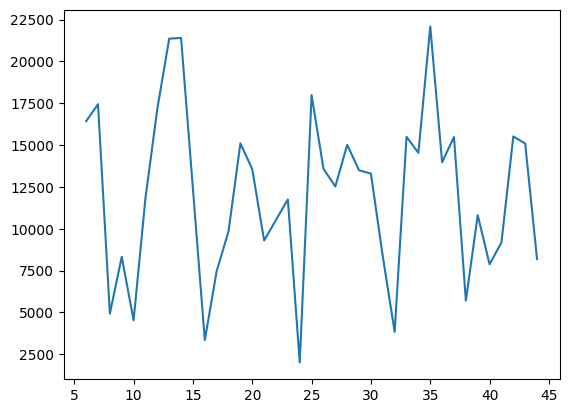

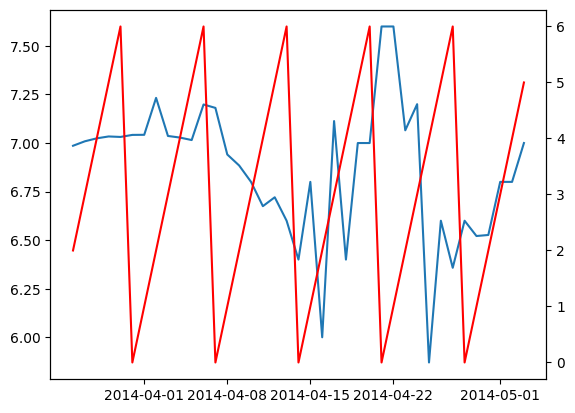

In [ ]:
new_df['screen_sum'].plot()
# plot day of the week on seperate y axis
fig, ax1 = plt.subplots()
ax1.plot(new_df['time'], new_df['mood_avg'])
ax2 = ax1.twinx()
ax2.plot(new_df['time'], new_df['day_of_week'], color='red')
